# Chatbot Test Notebook

This notebook is designed to test and experiment with the functionality of the chatbot implemented in the `rag_swimrules` project. It showcases various scenarios and evaluates the performance of the chatbot.

In [1]:
import textwrap
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import random

from langchain.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from langchain_chroma.vectorstores import Chroma
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

from openevals.prompts import CORRECTNESS_PROMPT
from openevals.llm import create_llm_as_judge


In [2]:


swimming_rules_template = """You are an expert swimming rules assistant trained on FINA and competitive swimming regulations. 
Your answers must be precise, factual, and based only on the provided rules. Follow these guidelines:

1. Answer ONLY using the verified rules provided below
2. DO NOT use information from any other sources, including the internet or personal knowledge.
3. if an action is not explicitly prohibited in the rules, assume it is allowed.
4. if an action is not explicity mentioned, assume it is allowed.
5. if an action is explicitly stated in the rule, follow what the rule says.
6. A disqualification must be based on a specific rule violation and cannot be implied.
7. If the information isn't in the rules, say "I don't have that rule in my current documentation"
8. Keep answers concise but complete
9. Reference specific rule numbers when possible

Relevant swimming rules:
{context}

Question: {question}

Answer:"""

SWIMMING_RULES_PROMPT = PromptTemplate(
    template=swimming_rules_template,
    input_variables=["context", "question"]
)


In [3]:
# reaad situations from json file
with open("../raw_data/swimming_situations2.json") as f:
    swimming_situations = json.load(f)

print(f"# of situations: {len(swimming_situations)}")

# of situations: 56


In [4]:
# Initialize embeddings model (ensure the same model used during creation)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# retretieve the relevant rules from your database or knowledge base
# Load the existing Chroma vector store
persist_directory = "../db/swim_rules_semantic"
vector_store = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

# Create a retriever from the vector store
retriever = vector_store.as_retriever(search_kwargs={"k": 10})



In [5]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=1000
)


In [6]:
print(f"Swimming situations: {len(swimming_situations)}")
for situation in swimming_situations[:5]:
    print(f"Situation: {situation}")

Swimming situations: 56
Situation: {'situation_id': 9, 'prompt': 'A breaststroke swimmer moves their hands in a sculling or flipper movement at the end of the first arm stroke, both after the start and after the turn. Should they be disqualified?', 'target': 'No, the swimmer should not be disqualified. This is legal provided, "All movements of the arms shall be simultaneous without alternating movement." A sculling motion of the hands, only as a part of the arm stroke, is not considered the beginning of a new stroke.', 'rule': '101.2.2'}
Situation: {'situation_id': 10, 'prompt': 'In a 9-10 100 yard breaststroke event, a swimmer completes 50 yards and, thinking that the race is over, pushes back from the wall to read the scoreboard. At this point, realizing that the race is only halfway over, the swimmer returns to the wall, pushes off on the breast, and completes the required distance in good form. What call, if any, should be made?', 'target': 'The swimmer left the wall on the back an

In [7]:
# setup evaluator
response_evaluator = create_llm_as_judge(
    prompt=CORRECTNESS_PROMPT,
    model="openai:gpt-4o",
    feedback_key="correctness"
)

In [8]:
random_sample = True

if random_sample:
    # Set random seed for reproducibility
    random.seed(42)

    # Take a random sample of swimming situations
    sample_size = 20  # Define the sample size
    sampled_situations = random.sample(swimming_situations, sample_size)
else:
    # Use the first 20 situations from the dataset
    sampled_situations = swimming_situations

test_results = []
for situation in sampled_situations:
    query = situation["prompt"]
    test_case = {"question": query, "situation": situation["situation_id"]}
    print()
    print(textwrap.fill(f"\n>>>SITUATION: {situation['situation_id']} QUERY: {query}", width=80))
    
    # Use the retriever to get relevant documents
    docs = retriever.get_relevant_documents(query)

    # Combine the retrieved documents into a context string
    context = "\n".join([doc.page_content for doc in docs])

    # Create the prompt template
    prompt = SWIMMING_RULES_PROMPT.format(context=context, question=query)

    start_time = time.time()
    response = llm(prompt)
    test_case["query_time"] = time.time() - start_time

    start_time = time.time()
    correctness_score = response_evaluator(inputs=query, outputs=response.content, reference_outputs=situation["target"])
    test_case["response_eval_time"] = time.time() - start_time

    test_case.update({
        "llm_response": response.content,
        "correctness_score": correctness_score["score"],
        "feedback": correctness_score["comment"],
        "target": situation["target"]
    })

    # Word wrap the response content if the line is longer than 80 characters
    wrapped_response = textwrap.fill(response.content, width=80)
    print(f">>>LLM RESPONSE: {wrapped_response}")
    print(f">>>TARGET: {textwrap.fill(situation['target'], width=80)}")

    print(f">>>CORRECTNESS SCORE: {correctness_score['key']}  {correctness_score['score']}")
    print(f"FEEDBACK: {textwrap.fill(correctness_score['comment'], width=80)}")

    test_results.append(test_case)



 >>>SITUATION: 109 QUERY: A swimmer begins the freestyle leg of the individual
medley by taking several butterfly kicks. The swimmer is disqualified for
swimming more than one quarter of the race in the style of butterfly. Is this a
correct disqualification?


/var/folders/8_/h2tjc94d2y5fwx8dhbcrnbfc0000gn/T/ipykernel_24460/1116270941.py:22: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)
/var/folders/8_/h2tjc94d2y5fwx8dhbcrnbfc0000gn/T/ipykernel_24460/1116270941.py:31: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(prompt)


>>>LLM RESPONSE: No, this is not a correct disqualification. According to rule 101.6.2, during
the freestyle leg of the individual medley, the swimmer may swim any style other
than butterfly, breaststroke, or backstroke. However, the rule does not
explicitly prohibit taking several butterfly kicks at the start of the freestyle
leg, as long as the swimmer does not swim the entire leg in the style of
butterfly. Therefore, the disqualification is not supported by the provided
rules.
>>>TARGET: No, this is not a correct disqualification. The butterfly kick is only one
element of butterfly; it is not the defining characteristic. A swimmer would
need to use both a butterfly kick, as well as a simultaneous double arm pull, in
which the arms recover over the surface of the water, in order to be
disqualified for swimming more than one quarter of the race in the style of
butterfly.
>>>CORRECTNESS SCORE: correctness  True
FEEDBACK: Analyzing the output, the response claims that the disqualificati

In [9]:
test_results_df = pd.DataFrame(test_results)
test_results_df

,question,situation,query_time,response_eval_time,llm_response,correctness_score,feedback,target
0,A swimmer begins the freestyle leg of the indi...,109,1.736148,3.037754,"No, this is not a correct disqualification. Ac...",True,"Analyzing the output, the response claims that...","No, this is not a correct disqualification. Th..."
1,To get further distance out of their breaststr...,16,0.809204,2.048289,"No, this is not legal. According to rule 101.2...",True,"Upon reviewing the output provided, the model ...","It is not legal. The rule states, “The hands s..."
2,"In a 9-10 100 yard breaststroke event, a swimm...",10,0.569680,2.872155,I don't have that rule in my current documenta...,False,"Upon review of the input and the output, the f...",The swimmer left the wall on the back and then...
3,A medley relay team would like to swim the rel...,126,1.039657,2.662803,"No, this is not legal. According to rule 101.7...",True,"Upon reviewing the provided output, the follow...","No, this is not legal. The rules require that ..."
4,A swimmer dives in to the pool to start the 10...,88,1.124468,1.843664,"Yes, the swimmer should be disqualified. Accor...",True,The output provides accurate and complete info...,Yes. The rule requires the head to break the s...
5,A swimmer wants to swim in the style of backst...,86,0.953326,2.150017,"No, this is not legal. According to rule 101.5...",True,This output correctly identifies that the atte...,"No. The rule states, “The forward start shall ..."
6,"In the 200 yard butterfly, a swimmer approachi...",43,1.664857,2.227123,The deck referee should not accept the call. A...,False,The provided output suggests that the swimmer'...,As long as the official can clearly see that t...
7,A swimmer in the 100 yard butterfly moves too ...,37,1.443029,2.662819,"No, this is not a valid disqualification. Acco...",False,The prompt describes a situation in swimming w...,"This is a correct call. The rule states, “Both..."
8,During the freestyle leg of the 200 yard medle...,131,1.837813,1.838382,"No, the relay team should not be disqualified....",False,The model output claims that the relay team sh...,"Yes, the relay team should be disqualified. Th..."
9,A swimmer swims the breaststroke in a way that...,15,1.017799,2.464086,"Yes, the coach is correct. According to rule 1...",False,"The given output states, ""Yes, the coach is co...","No, the coach is not. The rule states, “The ha..."


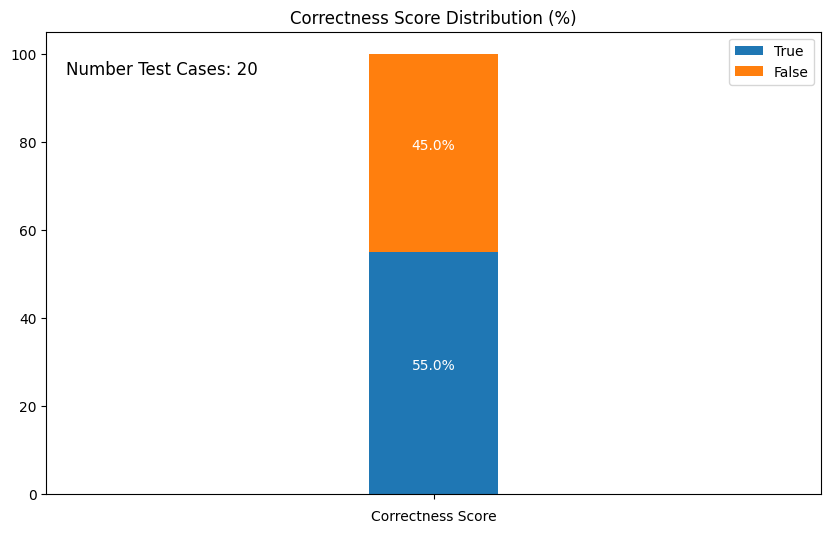

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 6))
# Set the figure size
# Calculate value counts and normalize to percentages
value_counts = test_results_df['correctness_score'].value_counts(normalize=True).mul(100)


# Create a stacked bar plot
df = pd.DataFrame(value_counts).T
df.columns = value_counts.index.astype(str).to_list()
df.rename(index={"proportion": 'correctness_score'}, inplace=True)
df = df[["True", "False"]]
df.plot.bar(stacked=True, ax=ax, width=0.1)
plt.title('Correctness Score Distribution (%)')
ax.set_xticklabels([], rotation=0)
plt.xlabel('Correctness Score')


# label the bars with percentage values
value_patches = zip(value_counts, ax.patches)
for value, patch in value_patches:
    height = patch.get_height()
    ax.annotate(f'{value:.1f}%', 
                xy=(patch.get_x() + patch.get_width() / 2, patch.get_y() + value / 2), 
                ha='center', va='bottom', fontsize=10, color="white")
    
# annotate chart with number of test cases
total_test_cases = len(test_results_df)
ax.annotate(f'Number Test Cases: {total_test_cases}', 
            xy=(0.15, 0.9), 
            ha='center', va='bottom', fontsize=12, color="black", xycoords='axes fraction')


# Create stacked bar plot

plt.show()